In [1]:
# using Plots
using LinearAlgebra
using PyPlot
using LazySets

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

Main.PostProcess

In [2]:
# test case 
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
z0 = 0
z1 = 1
ne = 10
ndim = 3
FunctionClass = "Q1";

In [3]:
# set up mesh grid
function meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)

    NodeList = zeros(ndim,(ne+1)^ndim)
    IEN = zeros(Int64,ne^ndim,2^ndim)

    BorderNodes = []
    BorderElements = []

    if ndim == 2
        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
    
        k = 1
        for i in 1:ne+1
            for j in 1:ne+1
                NodeList[1,k] = x[j]
                NodeList[2,k] = y[i]
                if i == 1 || i == ne+1 || j == 1 || j == ne+1
                    push!(BorderNodes,k)
                end
                k = k + 1
            end
        end
        
        l = 1
        for i in 1:ne
            for j in 1:ne
                IEN[l,1] = (i-1)*(ne+1) + j
                IEN[l,2] = (i-1)*(ne+1) + j + 1
                IEN[l,3] = i*(ne+1) + j + 1
                IEN[l,4] = i*(ne+1) + j
                l = l + 1
            end
        end

    elseif ndim == 3

        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
        z = collect(range(z0, z1, length=ne+1))
        
        m = 1
        for k in 1:ne+1
            for j in 1:ne+1
                for i in 1:ne+1
                    NodeList[1,m] = x[i]
                    NodeList[2,m] = y[j]
                    NodeList[3,m] = z[k]
                    if i == 1 || i == ne+1 || j == 1 || j == ne+1
                        push!(BorderNodes,m)
                    end
                    m = m + 1
                end
            end
        end
        
        l = 1
        for k in 1:ne
            for i in 1:ne
                for j in 1:ne
                    IEN[l,1] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,2] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,3] = (k-1)*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,4] = (k-1)*(ne+1)^2 + i*(ne+1) + j
                    IEN[l,5] = k*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,6] = k*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,7] = k*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,8] = k*(ne+1)^2 + i*(ne+1) + j
                    l = l + 1
                end
            end
        end
    end

    return NodeList, IEN, BorderNodes
end

NodeList, IEN, BorderNodes = meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim);

In [4]:
NodeListCyl = PostProcess.inflate_sphere(NodeList, x0, x1, y0, y1);

In [5]:
NodeListCylBrd = NodeListCyl[:,BorderNodes];

In [6]:
CameraMatrix = [[8*2048/7.07, 0.0, 2048/2] [0.0, 8*1536/5.3, 1536/2] [0.0, 0.0, 1.0]]

function backProject(NodeList, CameraMatrix)
""" Project the 3D mesh to 2D image plane and extract the border nodes (left and right)

Args:
    NodeList: 3D mesh grid
    CameraMatrix: Camera matrix

Returns:
    NodeList: 2D coordinates of the border nodes
"""
    # transform point cloud wrt to camera frame 

    R = [1 0 0; 0 0 1; 0 -1 0]
    t = [0; -0.5; 3]

    NodeListTrans = R*NodeList .+ t

    NodeListNorm = zeros(3,size(NodeListTrans,2))

    for i in 1:size(NodeListNorm,2)
        NodeListNorm[1,i] = NodeListTrans[1,i]/NodeListTrans[3,i]
        NodeListNorm[2,i] = NodeListTrans[2,i]/NodeListTrans[3,i]
        NodeListNorm[3,i] = NodeListTrans[3,i]/NodeListTrans[3,i]
    end
    
    NodeListProj = CameraMatrix'*NodeListNorm # project to image plane

    NodeList2D = NodeListProj[1:2,:] # extract x and y coordinates

    borderNodesList = [] # list to store indexes of the border nodes

    sz = size(NodeList2D,2)÷(ne+1) # size of each layer
    
    for Layers in 1:ne+1 # loop through each layer
        nodes = NodeList2D[:,(Layers-1)*sz+1:Layers*sz]
        minNode = (Layers-1)*sz + argmin(nodes[1,:])
        maxNode = (Layers-1)*sz + argmax(nodes[1,:])
        push!(borderNodesList,minNode,maxNode)
    end

    return NodeList2D[:,borderNodesList] # return the border nodes
end

NodeList2D = backProject(NodeListCylBrd, CameraMatrix);

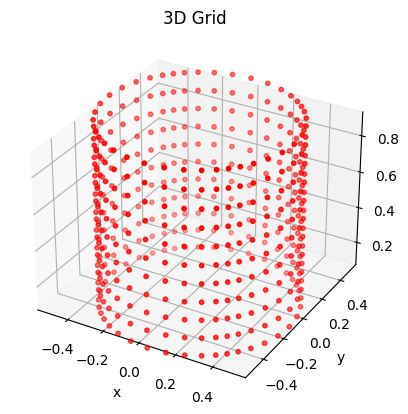

In [7]:
fig1 = figure()
ax = fig1.add_subplot(111, projection="3d")
ax.scatter(NodeListCylBrd[1,:],NodeListCylBrd[2,:],NodeListCylBrd[3,:],s=10,c="r")
ax.axis("equal")
ax.grid("on")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D Grid")

gcf()

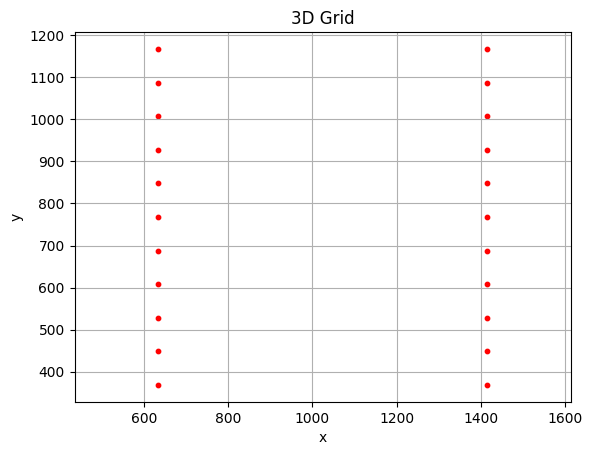

In [8]:
fig1 = figure()
ax = fig1.add_subplot(111)
ax.scatter(NodeList2D[1,:],NodeList2D[2,:],s=10,c="r")
ax.axis("equal")
ax.grid("on")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("3D Grid")

gcf()

In [9]:

# borderNodesList = []

# sz = size(NodeList2D,2)÷(ne+1)
# for Layers in 1:ne+1
#     nodes = NodeList2D[:,(Layers-1)*sz+1:Layers*sz]
#     minNode = (Layers-1)*sz + argmin(nodes[1,:])
#     maxNode = (Layers-1)*sz + argmax(nodes[1,:])
#     push!(borderNodesList,minNode,maxNode)
# end

# fig4 = figure()
# bx = fig4.add_subplot(111)
# bx.scatter(NodeList2D[1,:],NodeList2D[2,:],s=5, c="b", alpha=0.4)
# borderNodes = NodeList2D[:,borderNodesList]
# bx.scatter(borderNodes[1,:],borderNodes[2,:],s=10,c="r")
# bx.axis("equal")
# bx.grid("on")
# bx.set_xlabel("x")
# bx.set_ylabel("y")
# bx.set_title("2D Grid")

# gcf()

In [10]:
# function setboundaryCond(NodeList, ne, ndim)
#     # set dirichlet boundary conditions
#     q_d = zeros((ne+1)^ndim,1)
#     q_n = zeros((ne+1)^ndim,1)
#     Dbound1 = 0
#     Dbound2 = 1
#     Nbound = 0

#     # definition of the constraint matrix
#     C = Matrix{Int}(I,(ne+1)^ndim,(ne+1)^ndim)

#     for n in 1:length(q_d)
#         coord = NodeList[:,n] # get the coordinates of the node
#         if coord[2] == Dbound1 # bottom boundary
#             q_d[n] = 0
#         elseif coord[3] == Dbound2 # top boundary
#             q_d[2] = 1
#         end

#         if coord[1] == Nbound # left boundary
#             q_n[n] = 0
#         end 
#     end

#     C = C[:,((ne+1)^(ndim-1)+1):((ne+1)^ndim-(ne+1)^(ndim-1))]
    
#     return q_d, q_n, C
# end

# q_d, q_n, C = setboundaryCond(NodeList, ne, ndim);

In [11]:
# K = fem.assemble_system(ne, NodeList, IEN, ndim, FunctionClass)

# q_d, q_n, C = setboundaryCond(NodeList, ne, ndim)

# # transpose the constraint matrix
# C_t = transpose(C)

# # extract the free part of the stiffness matrix
# K_free = C_t*K*C

# b = q_n - K*q_d

# # solve the system
# q_f = K_free\C_t*b

# # assemble the solution 
# q = q_d + C*q_f;

In [12]:
# PostProcess.write_vtk("vtkFiles/isoParam3d","u",NodeList,IEN, ne, ndim, q)